In [ ]:
# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV

import time
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [2]:
heart = pd.read_csv('heart.csv')

# Data Description


## Heart Disease UCI

### Data Set Information:
Origin: [Cleveland database](https://archive.ics.uci.edu/ml/datasets/heart+Disease) from UCI Machine Learning Repository

The original database contains 76 attributes, but here only 14 attributes will be used :

1. age - age in years 
2. sex - (1 = male; 0 = female) 
3. cp - chest pain type 
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
    * anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl 
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
        - can range from mild symptoms to severe problems
        - signals non-normal heart beat
    * 2: Possible or definite left ventricular hypertrophy
        - Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved 
9. exang - exercise induced angina (1 = yes; 0 = no) 
10. oldpeak - ST depression induced by exercise relative to rest 
    * looks at stress of heart during excercise
    * unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy 
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising 
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

The last field contains the dependent "goal" attribute and refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. However, for sake of simplicity in this project the objective will be reduced to binary classification and will be concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

The names and social security numbers of the patients were removed from the database and replaced with dummy values.


# Readings 

## Recommended papers

* [Detrano R et al. 1989](https://www.ncbi.nlm.nih.gov/pubmed/2756873): International application of a new probability algorithm for the diagnosis of coronary artery disease
* [Al'Aref SJ et al. 2018](https://www.ncbi.nlm.nih.gov/pubmed/30060039): Clinical applications of machine learning in cardiovascular disease and its relevance to cardiac imaging

In [3]:
print(heart.info())
print(heart.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB
None
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
123   54    0   2       108   267    0        0      167      0      0.0   
69    62    0   0       124   209    0        1      163      0      0.0   
136   60    0   2       120   178    1        1       96      0      0.0   
111   57    1   2       150   126    1        1      173      0      0.2   
3     56    1   1     

In [4]:
# Distribution of Target
heart['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In [5]:
def prevalance(df, target):
    return df[target].sum()/len(df)

In [6]:
print('prevalance: {}'.format(prevalance(heart, 'target')))

prevalance: 0.5445544554455446


In [7]:
# Compute ECDF
def compute_ecdf(col):
    n = len(col) # number of observations
    x = np.sort(col)
    y = np.array(range(1, n+1))/n
    ecdf_df = pd.DataFrame({'X': x,
                           'Y': y})
    return ecdf_df

In [8]:
distribution_age = compute_ecdf(heart['age'])
distribution_trestbps = compute_ecdf(heart['trestbps'])
distribution_chol = compute_ecdf(heart['chol'])
distribution_thalach = compute_ecdf(heart['thalach'])
distribution_oldpeak = compute_ecdf(heart['oldpeak'])

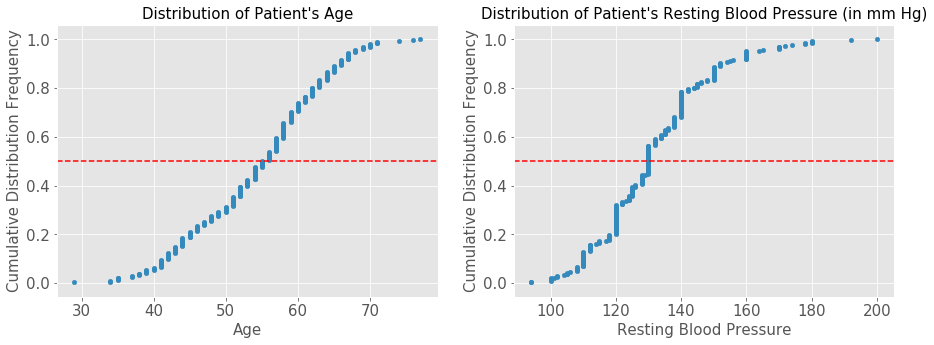

In [10]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,5), ncols=2)
# ax[0]
distribution_age.plot(kind='scatter',x='X', y='Y',ax=ax[0], fontsize=15)
ax[0].set_title("Distribution of Patient's Age", fontsize=15)
ax[0].set_xlabel('Age', fontsize=15)
ax[0].set_ylabel('Cumulative Distribution Frequency', fontsize=15)
ax[0].axhline(y=0.5, color='r', linestyle='--')

# ax[1]
distribution_trestbps.plot(kind='scatter', x='X', y='Y', ax=ax[1], fontsize=15)
ax[1].set_title("Distribution of Patient's Resting Blood Pressure (in mm Hg)", fontsize=15)
ax[1].set_xlabel('Resting Blood Pressure', fontsize=15)
ax[1].set_ylabel('Cumulative Distribution Frequency', fontsize=15)
ax[1].axhline(y=0.5, color='r', linestyle='--')

[Text(0, 0, 'Male'), Text(0, 0, 'Female')]

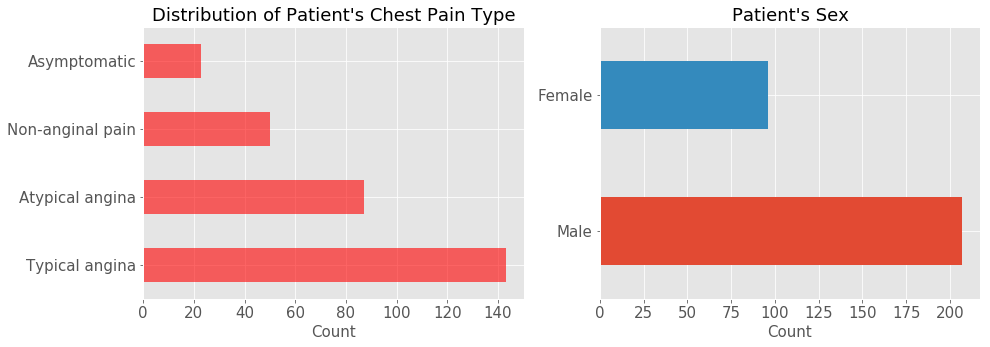

In [11]:
fig, ax = plt.subplots(figsize=(15,5), ncols=2)

# ax[0]
chest_pain = heart['cp'].value_counts()
chest_pain.plot(kind='barh', ax=ax[0], fontsize=15, color=(1, 0, 0, 0.6))
ax[0].set_title("Distribution of Patient's Chest Pain Type", fontsize=18)
ax[0].set_xlabel('Count', fontsize=15)
cp_labels = ['Typical angina', 'Atypical angina', 'Non-anginal pain', 'Asymptomatic']
ax[0].set_yticklabels(cp_labels, fontsize=15)

# ax[1]
patient_sex = heart['sex'].value_counts()
labels = ['Male', 'Female']
patient_sex.plot(kind='barh', ax=ax[1], fontsize=15)
ax[1].set_title("Patient's Sex", fontsize=18)
ax[1].set_xlabel('Count', fontsize=15)
ax[1].set_yticklabels(labels)

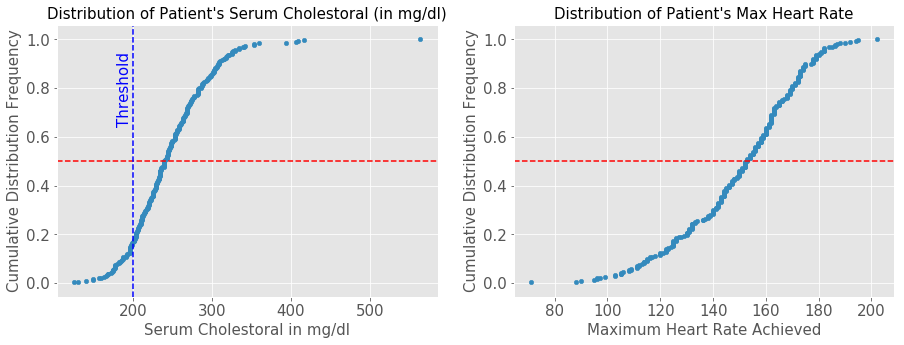

In [12]:
fig, ax = plt.subplots(figsize=(15,5), ncols=2)

# ax[0]
distribution_chol.plot(kind='scatter',x='X', y='Y',ax=ax[0], fontsize=15)
ax[0].set_title("Distribution of Patient's Serum Cholestoral (in mg/dl)", fontsize=15)
ax[0].set_xlabel('Serum Cholestoral in mg/dl', fontsize=15)
ax[0].set_ylabel('Cumulative Distribution Frequency', fontsize=15)
ax[0].axhline(y=0.5, color='r', linestyle='--')
ax[0].axvline(x=200, color='b', linestyle='--')
ax[0].text(180,0.9, 'Threshold', fontsize=15, color='blue', rotation=90)


# ax[1]
distribution_thalach.plot(kind='scatter', x='X', y='Y', ax=ax[1], fontsize=15)
ax[1].set_title("Distribution of Patient's Max Heart Rate", fontsize=15)
ax[1].set_xlabel('Maximum Heart Rate Achieved', fontsize=15)
ax[1].set_ylabel('Cumulative Distribution Frequency', fontsize=15)
ax[1].axhline(y=0.5, color='r', linestyle='--')

[Text(0, 0, 'False'), Text(0, 0, 'True')]

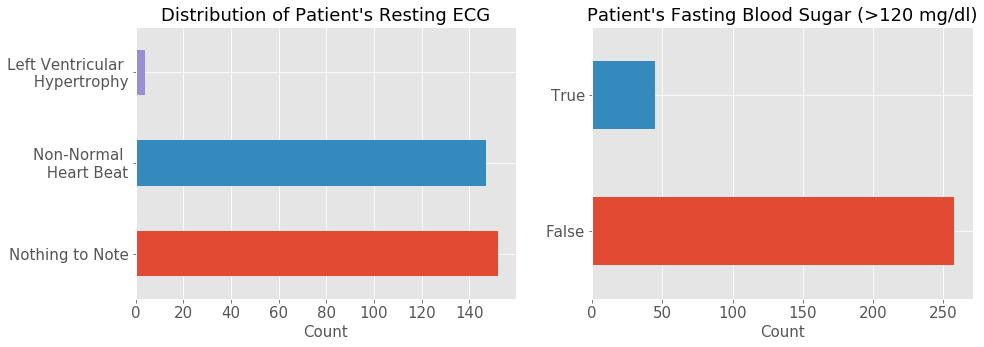

In [13]:
fig, ax = plt.subplots(figsize=(15,5), ncols=2)

# ax[0]
resting_ecg = heart['restecg'].value_counts()
resting_ecg.plot(kind='barh', ax=ax[0], fontsize=15)
ax[0].set_title("Distribution of Patient's Resting ECG", fontsize=18)
ax[0].set_xlabel('Count', fontsize=15)
ecg_labels = ['Nothing to Note', 'Non-Normal \n Heart Beat', 'Left Ventricular \n Hypertrophy'] 
ax[0].set_yticklabels(ecg_labels, fontsize=15)

# ax[1]
fbs = heart['fbs'].value_counts()
fbs.plot(kind='barh', ax=ax[1], fontsize=15)
ax[1].set_title("Patient's Fasting Blood Sugar (>120 mg/dl)", fontsize=18)
ax[1].set_xlabel('Count', fontsize=15)
ax[1].set_xticks
fbs_labels = ['False', 'True']
ax[1].set_yticklabels(fbs_labels)

In [14]:
#exang - exercise induced angina (1 = yes; 0 = no)
heart['exang'].value_counts()

0    204
1     99
Name: exang, dtype: int64

Text(0, 0.5, 'Cumulative Distribution Frequency')

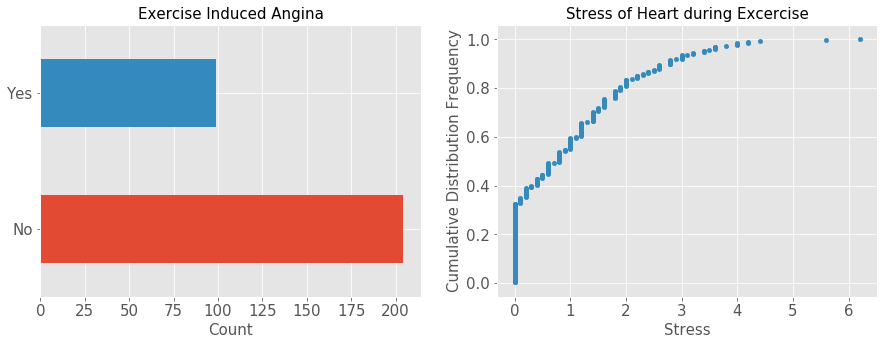

In [15]:
fig, ax = plt.subplots(figsize=(15,5), ncols=2)
# ax[0]
excercise_angia = heart['exang'].value_counts()
excercise_angia.plot(kind='barh',ax=ax[0], fontsize=15)
ax[0].set_title("Exercise Induced Angina", fontsize=15)
ax[0].set_xlabel('Count', fontsize=15)
exang_labels = ['No','Yes']
ax[0].set_yticklabels(exang_labels, fontsize=15)

# ax[1]
distribution_oldpeak.plot(kind='scatter', x='X', y='Y', ax=ax[1], fontsize=15)
ax[1].set_title("Stress of Heart during Excercise", fontsize=15)
ax[1].set_xlabel('Stress', fontsize=15)
ax[1].set_ylabel('Cumulative Distribution Frequency', fontsize=15)


[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4')]

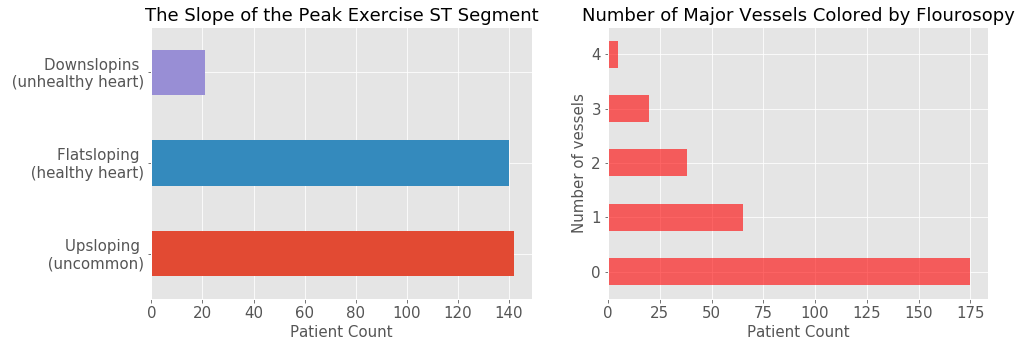

In [16]:
fig, ax = plt.subplots(figsize=(15,5), ncols=2)
# ax[0]

slope_excercise = heart['slope'].value_counts()
slope_excercise.plot(kind='barh', ax=ax[0], fontsize=15)
ax[0].set_title("The Slope of the Peak Exercise ST Segment", fontsize=18)
ax[0].set_xlabel('Patient Count', fontsize=15)
slope_labels=['Upsloping \n (uncommon)', 'Flatsloping \n (healthy heart)', 'Downslopins \n (unhealthy heart)']
ax[0].set_yticklabels(slope_labels, fontsize=15)

# ax[1]
num_maj_vessels = heart['ca'].value_counts()
num_maj_vessels.plot(kind='barh', ax=ax[1], fontsize=15, color=(1, 0, 0, 0.6))
ax[1].set_title("Number of Major Vessels Colored by Flourosopy", fontsize=18)
ax[1].set_ylabel('Number of vessels', fontsize=15)
ax[1].set_xlabel('Patient Count', fontsize=15)
ca_labels = [0, 1, 2, 3, 4]
ax[1].set_yticklabels(ca_labels, fontsize=15)


[Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3')]

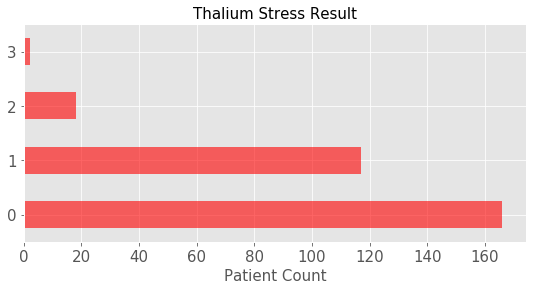

In [17]:
fig, ax = plt.subplots(figsize=(9,4))
# ax[0]
thalium_stress = heart['thal'].value_counts()
thalium_stress.plot(kind='barh', ax=ax, fontsize=15, color=(1, 0, 0, 0.6))
ax.set_title("Thalium Stress Result", fontsize=15)
ax.set_xlabel('Patient Count', fontsize=15)
thal_labels = [0,1,2,3]
ax.set_yticklabels(thal_labels, fontsize=15)

# Split data into Train-Validation_Test

In [21]:
heart = heart.copy()

valid_test = heart.sample(frac=0.3)
valid = valid_test.sample(frac=0.5)
test = valid_test.drop(valid.index)

train = heart.drop(valid_test.index)

print(valid.shape)
print(test.shape)
print(train.shape)

(46, 14)
(45, 14)
(212, 14)


In [22]:
train_y = train['target']
valid_y = valid['target']
test_y = test['target']

In [23]:
train.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [24]:
train_X = train.drop('target', axis=1)
valid_X = valid.drop('target', axis=1)
test_X = test.drop('target', axis=1)

# Linear Classifier

## Logistic Regression

In [28]:
## Baseline: Majority class prediction
baseline = float(len(test[test['target']==1]))/len(test)
print('Baseline accuracy (majority class classifier): {}'.format(baseline))

Baseline accuracy (majority class classifier): 0.5555555555555556


In [29]:
# Instantiate model
lr_model_1 = LogisticRegression()

# Fit on training data
lr_model_1.fit(train_X, train_y)

# Save model
filename = 'lr_model_1.sav'
pickle.dump(lr_model_1, open(filename, 'wb'))

# Load model and predict
pickle.load(open(filename, 'rb'))
lr_trn_preds = lr_model_1.predict(train_X)
lr_valid_preds = lr_model_1.predict(valid_X)

In [30]:
lr_01_trn_acc = accuracy_score(train_y, lr_trn_preds )
lr_01_val_acc = accuracy_score(valid_y, lr_valid_preds)
#lr_01_test_acc = accuracy_score(test_X, test_y)

lr_01_trn_pre = precision_score(train_y, lr_trn_preds )
lr_01_val_pre = precision_score(valid_y, lr_valid_preds)
#lr_01_test_pre = precision_score(test_X, test_y)

lr_01_trn_recall = recall_score(train_y, lr_trn_preds )
lr_01_val_recall = recall_score(valid_y, lr_valid_preds)
#lr_01_test_recall = recall_score(test_X, test_y)

lr_01_trn_auc = roc_auc_score(train_y, lr_trn_preds)
lr_01_val_auc = roc_auc_score(valid_y, lr_valid_preds)
#lr_01_test_auc = roc_auc_score(test_y, lr_test_preds)

In [31]:
print('Train AUC: {}'.format(lr_01_trn_auc))
print('Valid AUC: {}'.format(lr_01_val_auc))
#print('Test AUC: {}'.format(auc_test))

Train AUC: 0.8572649572649572
Valid AUC: 0.8913043478260869


## Fine Tune Logistic Regression

In [34]:
train_aucs = []
train_precision_scores = []
train_recall_scores = []

valid_aucs = []
valid_precision_scores = []
valid_recall_scores = []


Cs = [.00001, .00005, .0001,.0005,.001,.005,.01,.05, .1, .5, 1, 5, 10]

for ii in range(len(Cs)):
    C = Cs[ii]
    print('-'*50)
    print('C:', C)
    
    
    lr_model_02 = LogisticRegression(penalty= 'l2', C =C)
    
    lr_model_02.fit(train_X, train_y)
    
   
    model = lr_model_02
     #Predictions
    trn_preds = model.predict(train_X)
    valid_preds = model.predict(valid_X)
    
    # Metrics
    trn_auc = roc_auc_score(train_y, trn_preds)
    trn_pre_score = precision_score(train_y, trn_preds)
    trn_recall_score = recall_score(train_y, trn_preds)
    
    valid_auc = roc_auc_score(valid_y, valid_preds)
    valid_pre_score = precision_score(valid_y, valid_preds)
    valid_recall_score = recall_score(valid_y, valid_preds)
    
    # Append
    train_aucs.append(trn_auc)
    train_precision_scores.append(trn_pre_score)
    train_recall_scores.append(trn_recall_score)
    
    valid_aucs.append(valid_auc)
    valid_precision_scores.append(valid_pre_score)
    valid_recall_scores.append(valid_recall_score)
    
    print('Train AUC:%.3f' % trn_auc)
    print('Train Precision:%.3f' % trn_pre_score)
    print('Train Recall:%.3f' % trn_recall_score)
    print('-'*20)
    print('Valid AUC:%.3f' % valid_auc)
    print('Valid Precision:%.3f' % valid_pre_score)
    print('Valid Recall:%.3f' % valid_recall_score)

--------------------------------------------------
C: 1e-05
Train AUC:0.598
Train Precision:0.610
Train Recall:0.923
--------------------
Valid AUC:0.630
Valid Precision:0.594
Valid Recall:0.826
--------------------------------------------------
C: 5e-05
Train AUC:0.662
Train Precision:0.669
Train Recall:0.829
--------------------
Valid AUC:0.630
Valid Precision:0.600
Valid Recall:0.783
--------------------------------------------------
C: 0.0001
Train AUC:0.685
Train Precision:0.693
Train Recall:0.812
--------------------
Valid AUC:0.674
Valid Precision:0.643
Valid Recall:0.783
--------------------------------------------------
C: 0.0005
Train AUC:0.718
Train Precision:0.732
Train Recall:0.795
--------------------
Valid AUC:0.696
Valid Precision:0.667
Valid Recall:0.783
--------------------------------------------------
C: 0.001
Train AUC:0.733
Train Precision:0.746
Train Recall:0.803
--------------------
Valid AUC:0.674
Valid Precision:0.654
Valid Recall:0.739
-----------------------

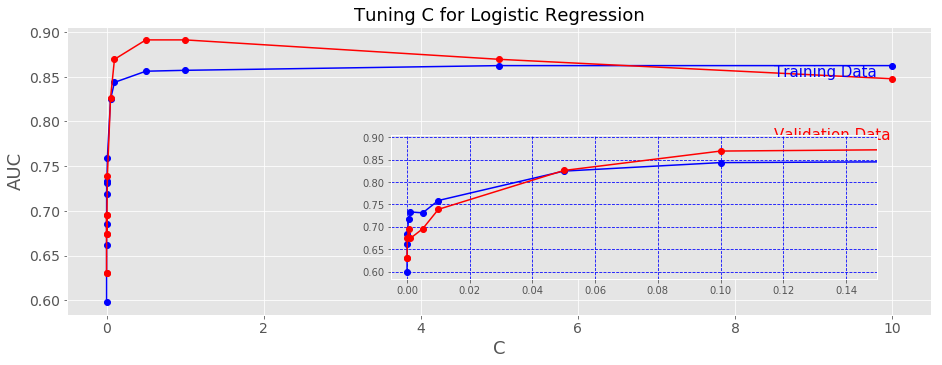

In [35]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax2 = fig.add_axes([0.4, 0.2, 0.45, 0.4])

ax1.plot(Cs, train_aucs, 'bo-', label='TRAIN')
ax1.plot(Cs, valid_aucs, 'ro-', label='VALID')
ax1.set_xlabel('C', fontsize=18)
ax1.set_ylabel('AUC', fontsize=18)
ax1.set_title('Tuning C for Logistic Regression', fontsize=18)
ax1.text(8.5, 0.85, 'Training Data', fontsize=15, color='blue')
ax1.text(8.5, 0.78, 'Validation Data', fontsize=15, color='red')
ax1.tick_params(axis='both', labelsize=14)

ax2.plot(Cs, train_aucs, 'bo-')
ax2.plot(Cs, valid_aucs, 'ro-')
ax2.set_xlim(-0.005, 0.15)
# Grid
ax2.grid(True, color='b', linestyle='dashed')

In [36]:
model_best_C = LogisticRegression(penalty='l2', C=0.1)

results = model_best_C.fit(train_X, train_y)
print('Intercept: {}'.format(results.intercept_))
print('\n')

coeff_df = pd.DataFrame({'Features': train_X.columns.tolist(),
                         'Coefficients': results.coef_.flatten()}).sort_values(by='Coefficients', ascending=False).reset_index(drop=True)
print(coeff_df)
print('\n')
print('Score on train set: ', model.score(train_X, train_y))
print('Score on valid set: ', model.score(valid_X, valid_y))
print('Score on test set: ', model.score(test_X, test_y))

Intercept: [0.04348963]


    Features  Coefficients
0         cp      0.559153
1    restecg      0.332456
2      slope      0.279519
3        fbs      0.092478
4    thalach      0.026661
5        age      0.003944
6       chol     -0.001268
7   trestbps     -0.020136
8      exang     -0.374841
9       thal     -0.429079
10   oldpeak     -0.440381
11        ca     -0.505705
12       sex     -0.515929


Score on train set:  0.8679245283018868
Score on valid set:  0.8478260869565217
Score on test set:  0.8444444444444444


# precision-recall tradeoff

We will explore the trade-off between precision and recall. We first examine what happens when we use a different threshold value for making class predictions. We then explore a range of threshold values and plot the associated precision-recall curve.

## Varying the threshold

**FALSE NEGATIVES** - Predicting someone as healthly (NO HEART DISEASE) when the person is actually having one - are costly mistakes in our case. So we want to be less conservative about making negative predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a lower threshold. 

In [38]:
def apply_threshold(probabilities, threshold):
    prediction = pd.Series(probabilities).apply(lambda probability: +1 if probability > threshold else 0)
    return prediction

Using the best model, let's compute the class probability values P(y=+1|x,w) for the data points in the test_data. Then we will use thresholds set at 0.5 (default) and 0.2 to make predictions from these probability values.

In [39]:
# sckit-learn predict_proba will return probablity values for class 0 and 1
probabilities = model_best_C.predict_proba(valid_X)[:,1]

In [40]:
# predictions at threshold 0.5
prediction_1 = apply_threshold(probabilities, 0.5)
sum(prediction_1==1)

25

In [41]:
# predictions at threshold 0.1
prediction_2 = apply_threshold(probabilities, 0.1)
sum(prediction_2==1)

40

## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. At a very low threshold, we would predict most of the patients having Heart Disease, hence the recall will be very high close to 1.0. However doing so will compromise the precision of the model. Recall that in the formula for precision the number of positive predictions is in the denominator and when this value increases the precision drops.

**Compute precision and recall for threshold values 0.1 and 0.5.**

In [44]:
# Precision at threshold 0.5
precision_1 = precision_score(valid_y, prediction_1)
print(precision_1)

# Precision at threshold 0.1
precision_2 = precision_score(valid_y, prediction_2)
print(precision_2)

# Recall at threshold 0.5
recall_1 = recall_score(valid_y, prediction_1) 
print(recall_1)

# Recall at threshold 0.1
recall_2 = recall_score(valid_y, prediction_2)
print(recall_2)

0.84
0.575
0.9130434782608695
1.0


## Precision-recall curve

At different values of thresholds, let's compute the precision and recall scores, and then plot the precision-recall curve.

In [45]:
threshold_values = np.linspace(0.1, 0.5, num = 100)
print(threshold_values)

[0.1        0.1040404  0.10808081 0.11212121 0.11616162 0.12020202
 0.12424242 0.12828283 0.13232323 0.13636364 0.14040404 0.14444444
 0.14848485 0.15252525 0.15656566 0.16060606 0.16464646 0.16868687
 0.17272727 0.17676768 0.18080808 0.18484848 0.18888889 0.19292929
 0.1969697  0.2010101  0.20505051 0.20909091 0.21313131 0.21717172
 0.22121212 0.22525253 0.22929293 0.23333333 0.23737374 0.24141414
 0.24545455 0.24949495 0.25353535 0.25757576 0.26161616 0.26565657
 0.26969697 0.27373737 0.27777778 0.28181818 0.28585859 0.28989899
 0.29393939 0.2979798  0.3020202  0.30606061 0.31010101 0.31414141
 0.31818182 0.32222222 0.32626263 0.33030303 0.33434343 0.33838384
 0.34242424 0.34646465 0.35050505 0.35454545 0.35858586 0.36262626
 0.36666667 0.37070707 0.37474747 0.37878788 0.38282828 0.38686869
 0.39090909 0.39494949 0.3989899  0.4030303  0.40707071 0.41111111
 0.41515152 0.41919192 0.42323232 0.42727273 0.43131313 0.43535354
 0.43939394 0.44343434 0.44747475 0.45151515 0.45555556 0.4595

In [46]:
precision_all = [precision_score(valid_y, apply_threshold(
    probabilities, threshold)) for threshold in threshold_values]
recall_all = [recall_score(valid_y, apply_threshold(
    probabilities, threshold)) for threshold in threshold_values]

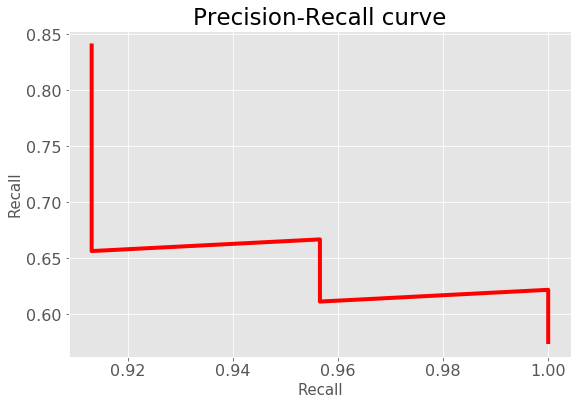

In [94]:
def plot_pr_curve(precision, recall):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(recall, precision, 'b-', linewidth=4.0, color = 'red')
    ax.set_title('Precision-Recall curve')
    ax.set_xlabel('Recall', fontsize=15)
    ax.set_ylabel('Recall', fontsize=15)
    
plot_pr_curve(precision_all, recall_all, )

In [51]:
new_thresholds = []

for i in zip(threshold_values, precision_all):
    thre, preci = i

    if preci >= 0.8:
        new_thresholds.append(thre)

print(min(new_thresholds))

0.45959595959595956


In [52]:
test_probabilities = model_best_C.predict_proba(test_X)[:,1]

# Confusion matrix at optimum threshold
cmat = confusion_matrix(y_true=test_y,
                        y_pred=apply_threshold(test_probabilities, 0.5),
                        labels=model_best_C.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))


 target_label | predicted_label | count 
--------------+-----------------+-------
      0       |        0        |    15
      0       |        1        |     5
      1       |        0        |     1
      1       |        1        |    24


In [53]:
# Confusion matrix at optimum threshold
cmat_optimum = confusion_matrix(y_true=test_y,
                        y_pred=apply_threshold(test_probabilities, 0.46),
                        labels=model_best_C.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat_optimum[i,j]))


 target_label | predicted_label | count 
--------------+-----------------+-------
      0       |        0        |    15
      0       |        1        |     5
      1       |        0        |     1
      1       |        1        |    24


# Tree Based models

In [ ]:
## Random Forest

In [55]:
rf_model_01 = RandomForestClassifier()
rf_model_01

rf_model_01.fit(train_X, train_y)

filename = 'rf_model_01.sav'
pickle.dump(rf_model_01, open(filename, 'wb'))

pickle.load(open(filename, 'rb'))


rf_trn_preds = rf_model_01.predict(train_X)
rf_valid_preds = rf_model_01.predict(valid_X)

print('Train Precision:{}'.format(precision_score(train_y, rf_trn_preds)))
print('Train Recall:{}'.format(recall_score(train_y, rf_trn_preds)))
print('Validation Precision:{}'.format(precision_score(valid_y, rf_valid_preds)))
print('Validation Recall:{}'.format(recall_score(valid_y, rf_valid_preds)))

Train Precision:0.9914529914529915
Train Recall:0.9914529914529915
Validation Precision:0.8260869565217391
Validation Recall:0.8260869565217391


In [57]:
models=[]
model_scores =[]

In [58]:

display(pd.crosstab(index=valid_y, columns="count"))
print('\nClassification report:\n', classification_report(valid_y, rf_valid_preds))
print('\nConfusion matrix:\n',confusion_matrix(valid_y, rf_valid_preds))
print('\nF1-score: ',f1_score(valid_y, rf_valid_preds))

models.append('Random Forest')
model_scores.append(f1_score(valid_y, rf_valid_preds))

col_0,count
target,
0,23
1,23



Classification report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        23
           1       0.83      0.83      0.83        23

   micro avg       0.83      0.83      0.83        46
   macro avg       0.83      0.83      0.83        46
weighted avg       0.83      0.83      0.83        46


Confusion matrix:
 [[19  4]
 [ 4 19]]

F1-score:  0.8260869565217391


In [59]:
## Hypertuning Parameters for Random Forest

In [60]:
rf_model_01

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [61]:
random_grid = {'n_estimators':[int(x) for x in np.linspace(start=100, stop=1000, num=10)],
               'max_depth':[int(depth) for depth in np.linspace(50, 400, num=20)],
               'max_features':['auto', 'log2'],
               "min_samples_leaf":[2,4,6,8,10,12,14,16],
               "min_samples_split":[2,5,10,15,20, 25, 30],
               "bootstrap":['True', 'False']}

In [62]:
rf = RandomForestClassifier()
rf_model = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter=100, cv=3, verbose=True, random_state=42, n_jobs=-1)

In [63]:
rf_model.fit(train_X, train_y)

best_model = rf_model.best_estimator_
best_model

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   32.4s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=307, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
rf_model_02 = RandomForestClassifier(bootstrap='False', class_weight=None, criterion='gini',
            max_depth=307, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf_model_02.fit(train_X, train_y)


RandomForestClassifier(bootstrap='False', class_weight=None, criterion='gini',
            max_depth=307, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [66]:
filename = 'rf_model_02.sav'
pickle.dump(rf_model_02, open(filename, 'wb'))

pickle.load(open(filename, 'rb'))

RandomForestClassifier(bootstrap='False', class_weight=None, criterion='gini',
            max_depth=307, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [67]:
rf_2_trn_preds = rf_model_02.predict(train_X)
rf_2_valid_preds = rf_model_02.predict(valid_X)

In [68]:

display(pd.crosstab(index=valid_y, columns="count"))
print('\nClassification report:\n', classification_report(valid_y, rf_2_valid_preds))
print('\nConfusion matrix:\n',confusion_matrix(valid_y, rf_2_valid_preds))
print('\nF1-score: ',f1_score(valid_y, rf_2_valid_preds))

models.append('Random Forest')
model_scores.append(f1_score(valid_y, rf_2_valid_preds))

col_0,count
target,
0,23
1,23



Classification report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.84        23
           1       0.81      0.91      0.86        23

   micro avg       0.85      0.85      0.85        46
   macro avg       0.85      0.85      0.85        46
weighted avg       0.85      0.85      0.85        46


Confusion matrix:
 [[18  5]
 [ 2 21]]

F1-score:  0.8571428571428572


In [69]:
# Gradient Boosting MAchines

In [70]:
# Instantiate a classifier
model_03 = GradientBoostingClassifier()

# Fit a model
model_03.fit(train_X,train_y)

# Save and load the model
filename = 'gbm_base_model_MF.sav'
pickle.dump(model_03, open(filename, 'wb'))
model_03 = pickle.load(open(filename, 'rb'))


# Predict the labels of the train and valid data
trn_preds_03 = model_03.predict(train_X)
valid_preds_03 = model_03.predict(valid_X)

In [71]:
model_03

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [72]:

display(pd.crosstab(index=valid_y, columns="count"))
print('\nClassification report:\n', classification_report(valid_y, valid_preds_03))
print('\nConfusion matrix:\n',confusion_matrix(valid_y, valid_preds_03))
print('\nF1-score: ',f1_score(valid_y, valid_preds_03))

models.append('Gradient Boosting Classifier')
model_scores.append(f1_score(valid_y, valid_preds_03))

col_0,count
target,
0,23
1,23



Classification report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82        23
           1       0.80      0.87      0.83        23

   micro avg       0.83      0.83      0.83        46
   macro avg       0.83      0.83      0.83        46
weighted avg       0.83      0.83      0.83        46


Confusion matrix:
 [[18  5]
 [ 3 20]]

F1-score:  0.8333333333333333


In [73]:
params_GB_RS = {"max_depth": np.linspace(1, 50, 1, endpoint=True),
                "max_features": ['auto', 'sqrt', 'log2'],
                "min_samples_split": np.linspace(.1, 1, 10, endpoint=True),
                "min_samples_leaf": [0.1, 0.2, 0.3, 0.4, 0.5],
                "learning_rate": [0.001, 0.01, 0.1, 0.2, 1, 2]}


model_04 = RandomizedSearchCV(model_03, param_distributions=params_GB_RS,
                                 n_iter=100, cv=3, verbose=True, random_state=42, n_jobs=-1)

model_04.fit(train_X, train_y)

best_GBM = model_04.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.9s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [74]:
best_GBM

{'learning_rate': 0.01,
 'max_depth': 1.0,
 'max_features': 'auto',
 'min_samples_leaf': 0.2,
 'min_samples_split': 0.9}

In [79]:
model_05 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=1,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.2, min_samples_split=0.9,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [80]:
model_05.fit(train_X, train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=1,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=0.2, min_samples_split=0.9,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [81]:
# Predict the labels of the train and valid data
trn_preds_05 = model_05.predict(train_X)
valid_preds_05 = model_05.predict(valid_X)

In [82]:
display(pd.crosstab(index=valid_y, columns="count"))
print('\nClassification report:\n', classification_report(valid_y, valid_preds_05))
print('\nConfusion matrix:\n',confusion_matrix(valid_y, valid_preds_05))
print('\nF1-score: ',f1_score(valid_y, valid_preds_05))

models.append('Gradient Boosting Classifier')
model_scores.append(f1_score(valid_y, valid_preds_05))

col_0,count
target,
0,23
1,23



Classification report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        23
           1       0.83      0.87      0.85        23

   micro avg       0.85      0.85      0.85        46
   macro avg       0.85      0.85      0.85        46
weighted avg       0.85      0.85      0.85        46


Confusion matrix:
 [[19  4]
 [ 3 20]]

F1-score:  0.851063829787234


In [ ]:
# Model Interpretation

In [83]:
import eli5
from eli5.sklearn import PermutationImportance

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [84]:
perm = PermutationImportance(model_05, random_state=1).fit(valid_X, valid_y)
eli5.show_weights(perm, feature_names = valid_X.columns.tolist())

Weight,Feature
0.0870 ± 0.0389,cp
0.0391 ± 0.0507,thal
0.0261 ± 0.0639,ca
0.0261 ± 0.0426,oldpeak
0.0174 ± 0.0325,sex
0.0130 ± 0.0348,slope
0.0000 ± 0.0275,exang
0 ± 0.0000,thalach
0 ± 0.0000,fbs
0 ± 0.0000,chol


In [ ]:
Features at the top of the list such as cp, and ca are the most important features.
cp - chest pain type
ca - number of major vessels (0-3) colored by flourosopy

The model performance decreased by 0.0522 with a random shuffling. 
The number after +/- measures how performance varied from 
one-shuffling to the next. 





Now that we identified the important features, let's try to understand how a feature affects predictions using Partial Dependence Plots

## Partial Dependence Plots

In [55]:
from pdpbox import pdp, get_dataset, info_plots

In [59]:
print(valid_X.shape)
print(len(valid_X.columns.tolist()))
print(valid_y.shape)

(46, 13)
13
(46,)


In [83]:
pdp_cp = pdp.pdp_isolate(model=model_05, dataset=valid,
                         model_features=valid_X.columns.tolist(), feature='cp')
pdp_ca = pdp.pdp_isolate(model=model_05, dataset=valid,
                         model_features=valid_X.columns.tolist(), feature='ca')
pdp_thal = pdp.pdp_isolate(model=model_05, dataset=valid,
                           model_features=valid_X.columns.tolist(), feature='thal')
pdp_chol = pdp.pdp_isolate(model=model_05, dataset=valid,
                           model_features=valid_X.columns.tolist(), feature='chol')
pdp_thalach = pdp.pdp_isolate(model=model_05, dataset=valid, 
                              model_features = valid_X.columns.tolist(), feature='thalach')
pdp_age = pdp.pdp_isolate(model=model_05, dataset=valid, 
                              model_features = valid_X.columns.tolist(), feature='age')

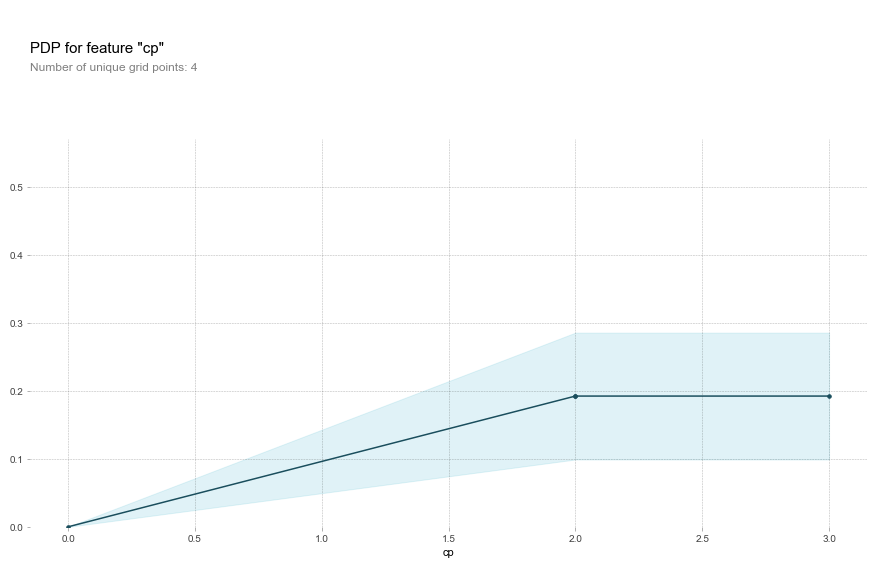

In [84]:
pdp.pdp_plot(pdp_cp, 'cp')
plt.show()

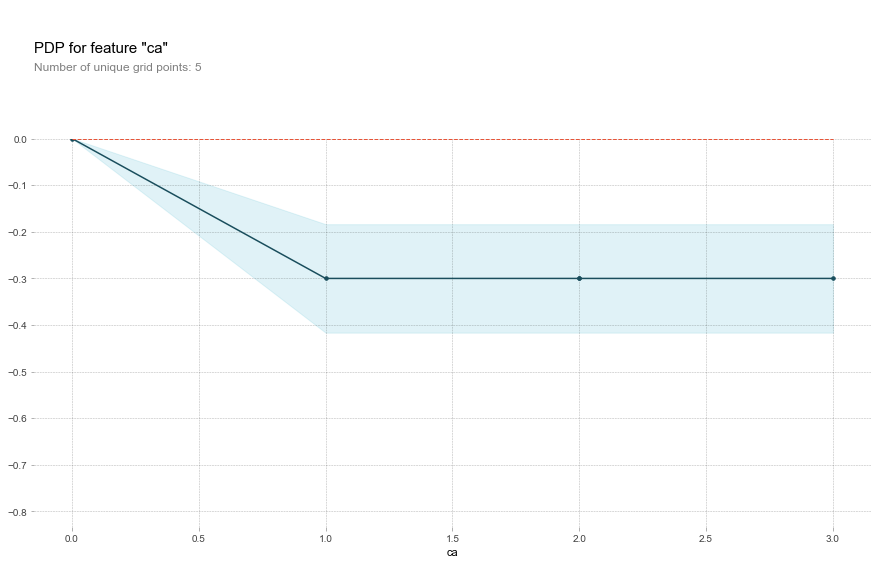

In [86]:
pdp.pdp_plot(pdp_ca, 'ca')
plt.show()

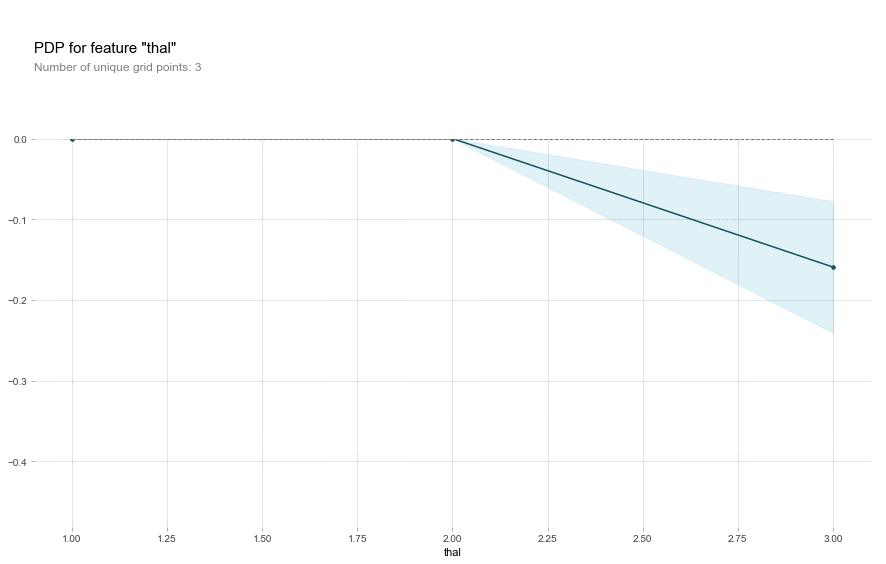

In [87]:
pdp.pdp_plot(pdp_thal, 'thal')
plt.show()

In [93]:
import shap

In [61]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model_05)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

NameError: name 'data_for_prediction' is not defined

In [94]:
shap.initjs()

In [95]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(model_05.predict_proba, train_X)
k_shap_values = k_explainer.shap_values(valid_X)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], valid_X)

Using 212 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.
100%|██████████| 46/46 [01:17<00:00,  1.70s/it]


In [ ]:
# XGBoost